In [10]:
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split


In [62]:
df = pd.read_csv("../data/OHLC/all_tickers.csv", encoding='utf-8')

In [63]:
df = df.drop(columns = ['Unnamed: 0'])

In [64]:
def change_label_val(label):
    if label == "Neutral":
        return 0
    elif label == "Positive":
        return 1
    else:
        return -1
df["Output"] = df.Sentiment.apply(change_label_val)

In [65]:
df.tail()

,Quarter,Year,Company,Summary,Q&A,date,percent change (between t-2 and t+2),Sentiment,Output
361,Q3,2017,Cisco,welcome cisco systems third quarter fiscal yea...,want see could understand guidance kelly chuck...,2017-08-16,-2.512560,Neutral,0
362,Q3,2020,Cisco,thank michelle welcome everyone cisco third qu...,first question come paul silverstein cowen com...,2020-08-12,-10.496541,Negative,-1
363,Q3,2020,Cisco,thank michelle welcome everyone cisco third qu...,first question come paul silverstein cowen com...,2020-08-12,-10.496541,Negative,-1
364,Q4,2016,Cisco,thank sam welcome everyone cisco fourth quarte...,thank first question come line vijay bhagavath...,2016-11-16,-4.207835,Negative,-1
365,Q4,2016,Cisco,thank sam welcome everyone cisco fourth quarte...,thank first question total line vijay bhagavat...,2016-11-16,-4.207835,Negative,-1


## For summary

In [99]:
df_merged = df
X,y = df_merged['Summary'].values,df_merged['Sentiment'].values

x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)

In [100]:
def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    for sent in x_train:
        for word in sent.lower().split():
            if  word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
#     corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:10000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[(word)] for word in sent.lower().split() 
                                     if (word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[(word)] for word in sent.lower().split() 
                                    if (word) in onehot_dict.keys()])
            
#     encoded_train = [1 if label =='positive' else 0 for label in y_train]  
#     encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train),np.array(final_list_test),onehot_dict


In [101]:
x_train,x_test,vocab = tockenize(x_train,y_train,x_test,y_test)

/var/folders/sh/cctyhsnj2vbcvbdy473jdb180000gn/T/ipykernel_17313/444484457.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train),np.array(final_list_test),onehot_dict


In [102]:
def encode_labels(y):
    y_labels = []
    for i in y:
        if i =='Positive':
            y_labels.append(1)
        elif i == 'Negative':
            y_labels.append(-1)
        else:
            y_labels.append(0)
    return np.array(y_labels)

y_train = encode_labels(y_train)
y_test = encode_labels(y_test)

In [103]:
x_train1 = pd.DataFrame(x_train)
def lengthCreator(sent):
    return len(sent)
x_train1['length'] = x_train1[0].apply(lengthCreator)
x_train1.length.max()

3081

In [104]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features


In [105]:
x_train_pad = padding_(x_train,2000)
x_test_pad = padding_(x_test,2000)

In [106]:
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 2

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [107]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([2, 2000])
Sample input: 
 tensor([[   0,    0,    0,  ..., 1041,  716,  124],
        [  15,  346,   18,  ...,  202, 2434,   82]])
Sample input: 
 tensor([-1,  0])


In [108]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first = True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
#         import pdb; pdb.set_trace()
        batch_size = x.size(0)
#         print("Forward batch size:")
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim))
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim))
#         print("H0 shape: ",h0.shape)
        hidden = (h0,c0)
        return hidden


In [109]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

# #moving to gpu
# model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(9707, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [21]:
# loss and optimization functions
lr=0.0001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [23]:
clip = 5
epochs = 10
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs, labels
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs, labels

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '../working_summ/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.3461354342527198 val_loss : 0.27339562441667786
train_accuracy : 40.51094890510949 val_accuracy : 40.21739130434783
Validation loss decreased (inf --> 0.273396).  Saving model ...
Epoch 2
train_loss : 0.09197835142921357 val_loss : 0.0895684557845411
train_accuracy : 40.51094890510949 val_accuracy : 40.21739130434783
Validation loss decreased (0.273396 --> 0.089568).  Saving model ...
Epoch 3
train_loss : 0.09937862020388907 val_loss : 0.8282811183143286
train_accuracy : 40.87591240875913 val_accuracy : 40.21739130434783
Epoch 4
train_loss : -0.37237083561183976 val_loss : -0.3543676259135321
train_accuracy : 43.79562043795621 val_accuracy : 45.65217391304348
Validation loss decreased (0.089568 --> -0.354368).  Saving model ...
Epoch 5
train_loss : -0.9428038449625663 val_loss : -0.1780585092694863
train_accuracy : 49.27007299270073 val_accuracy : 43.47826086956522
Epoch 6
train_loss : -1.6604034535588001 val_loss : -0.40284142950876545
train_accuracy : 55.109489

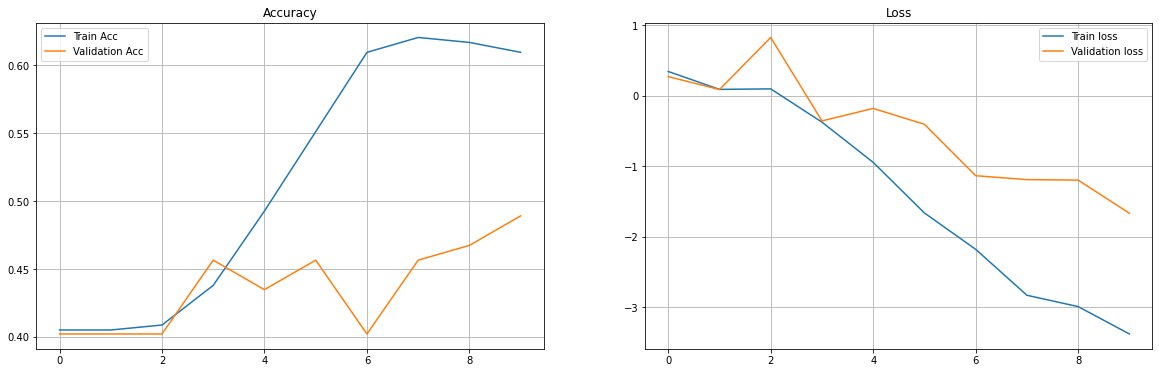

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [26]:
def predict_text(text):
    word_seq = np.array([vocab[(word)] for word in text.split() 
                     if (word) in vocab.keys()])
    word_seq = np.expand_dims(word_seq,axis=0)
    pad =  torch.from_numpy(padding_(word_seq,2000))
    inputs = pad
    batch_size = 1
    h = model.init_hidden(batch_size)
    h = tuple([each.data for each in h])
    output, h = model(inputs, h)
    return(output.item())

In [27]:
predicted_labels = []
for index in range(len(df_merged['Summary'])):
#     print(df_merged['Summary'][index])
#     print('='*70)
#     print(f'Actual sentiment is  : {df_merged["Sentiment"][index]}')
#     print('='*70)
    pro = predict_text(df_merged['Summary'][index])
    if pro > 0.6:
        status = "Positive"
    elif pro >= 0.4 and pro <= 0.6:
        status = "Neutral"
    else:
        status = "Negative"
#     status = "positive" if pro > 0.8 else "negative"
#     pro = (1 - pro) if status == "Negative" else pro
    predicted_labels.append(status)
#     print(f'Predicted sentiment is {status} with a probability of {pro}')

In [28]:
df10 = pd.DataFrame(predicted_labels, columns=['predict'])
df10
# df11 = pd.concat(df_merged, df10)

df11 = pd.concat([df_merged, df10], axis = 1)
df11

,Quarter,Year,Company,Summary,Q&A,date,percent change (between t-2 and t+2),Sentiment,Output,predict
0,Q4,2019,Amazon,hello welcome q4 2019 financial result confere...,great really appreciate aws business look sort...,2019-10-24,-0.249190,Neutral,0,Negative
1,Q4,2019,Amazon,hello welcome q4 2019 financial result confere...,great really appreciate aws business look sort...,2019-10-24,-0.249190,Neutral,0,Negative
2,Q1,2016,Amazon,good day everyone welcome amazon com q1 2016 f...,thank lot lot international retail revenue int...,2016-01-28,-2.370061,Neutral,0,Negative
3,Q1,2016,Amazon,good 24 hour interval everyone welcome amazon ...,thank lot lot external retail revenue internat...,2016-01-28,-2.370061,Neutral,0,Negative
4,Q3,2019,Amazon,hello welcome q3 2019 financial result confere...,want know go little bite deeper framework give...,2019-07-25,-2.579112,Neutral,0,Negative
...,...,...,...,...,...,...,...,...,...,...
361,Q3,2017,Cisco,welcome cisco systems third quarter fiscal yea...,want see could understand guidance kelly chuck...,2017-08-16,-2.512560,Neutral,0,Negative
362,Q3,2020,Cisco,thank michelle welcome everyone cisco third qu...,first question come paul silverstein cowen com...,2020-08-12,-10.496541,Negative,-1,Negative
363,Q3,2020,Cisco,thank michelle welcome everyone cisco third qu...,first question come paul silverstein cowen com...,2020-08-12,-10.496541,Negative,-1,Negative
364,Q4,2016,Cisco,thank sam welcome everyone cisco fourth quarte...,thank first question come line vijay bhagavath...,2016-11-16,-4.207835,Negative,-1,Negative


In [127]:
c = 0
for i in range(len(df11['Sentiment'])):
    if df11['Sentiment'][i] == df11['predict'][i]:
        c += 1
print(c/len(df11['Sentiment']))

0.505464480874317


### Precision, Recall and F-1

In [135]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [141]:
print("Precision: ", precision_score(df11['Sentiment'], df11["predict"], average="macro"))
print("Recall: ", recall_score(df11['Sentiment'], df11["predict"], average="macro"))
print("F1 score: ", f1_score(df11['Sentiment'], df11["predict"], average="macro"))

Precision:  0.5600267457410314
Recall:  0.5756271896896897
F1 score:  0.4438617866628191


# For QnA

In [111]:
df_merged = df
X,y = df_merged['Q&A'].values,df_merged['Sentiment'].values

x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)

In [112]:
def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    for sent in x_train:
        for word in sent.lower().split():
            if  word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
#     corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:10000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[(word)] for word in sent.lower().split() 
                                     if (word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[(word)] for word in sent.lower().split() 
                                    if (word) in onehot_dict.keys()])
            
#     encoded_train = [1 if label =='positive' else 0 for label in y_train]  
#     encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train),np.array(final_list_test),onehot_dict


In [113]:
x_train,x_test,vocab = tockenize(x_train,y_train,x_test,y_test)

/var/folders/sh/cctyhsnj2vbcvbdy473jdb180000gn/T/ipykernel_17313/444484457.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train),np.array(final_list_test),onehot_dict


In [114]:
def encode_labels(y):
    y_labels = []
    for i in y:
        if i =='Positive':
            y_labels.append(1)
        elif i == 'Negative':
            y_labels.append(-1)
        else:
            y_labels.append(0)
    return np.array(y_labels)

y_train = encode_labels(y_train)
y_test = encode_labels(y_test)

In [115]:
x_train1 = pd.DataFrame(x_train)
def lengthCreator(sent):
    return len(sent)
x_train1['length'] = x_train1[0].apply(lengthCreator)
x_train1.length.max()

4400

In [116]:
x_train1

,0,length
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 11...",1952
1,"[699, 181, 35, 537, 700, 1, 142, 701, 10, 187,...",2633
2,"[646, 496, 263, 814, 360, 573, 1239, 991, 1241...",2492
3,"[341, 263, 317, 902, 4, 1559, 1560, 1561, 1562...",3084
4,"[317, 360, 14, 10, 181, 1040, 35, 40, 41, 56, ...",2962
...,...,...
269,"[317, 8429, 264, 712, 1349, 1350, 1351, 1629, ...",2292
270,"[646, 142, 263, 1719, 4, 5, 6, 2611, 1388, 174...",2097
271,"[646, 2861, 2191, 2192, 2427, 10139, 9801, 776...",2302
272,"[3418, 317, 2597, 7, 453, 3, 424, 375, 710, 45...",2339


In [117]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features


In [119]:
x_train_pad = padding_(x_train,4000)
x_test_pad = padding_(x_test,4000)

In [120]:
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 2

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [121]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([2, 4000])
Sample input: 
 tensor([[   0,    0,    0,  ...,  698, 6184,  449],
        [   0,    0,    0,  ..., 1240,  885,  371]])
Sample input: 
 tensor([ 0, -1])


In [122]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model_qna = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

# #moving to gpu
# model.to(device)

print(model_qna)

SentimentRNN(
  (embedding): Embedding(10185, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [123]:
# loss and optimization functions
lr=0.0001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model_qna.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [124]:
clip = 5
epochs = 10
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model_qna.train()
    # initialize hidden state 
    h = model_qna.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs, labels
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model_qna.zero_grad()
        output,h = model_qna(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model_qna.parameters(), clip)
        optimizer.step()
 
    val_h = model_qna.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model_qna.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs, labels

            output, val_h = model_qna(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model_qna.state_dict(), '../working_qna/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.506117066273289 val_loss : 0.32615163808931474
train_accuracy : 40.51094890510949 val_accuracy : 40.21739130434783
Validation loss decreased (inf --> 0.326152).  Saving model ...
Epoch 2
train_loss : 0.34389640363681057 val_loss : 0.2918411099716373
train_accuracy : 40.51094890510949 val_accuracy : 40.21739130434783
Validation loss decreased (0.326152 --> 0.291841).  Saving model ...
Epoch 3
train_loss : 0.3138122913719964 val_loss : 0.2749378858539073
train_accuracy : 40.51094890510949 val_accuracy : 40.21739130434783
Validation loss decreased (0.291841 --> 0.274938).  Saving model ...
Epoch 4
train_loss : 0.2842987434272348 val_loss : 0.31658655340256897
train_accuracy : 40.51094890510949 val_accuracy : 40.21739130434783
Epoch 5
train_loss : 0.2500403710525401 val_loss : 0.2796524475207147
train_accuracy : 40.51094890510949 val_accuracy : 40.21739130434783
Epoch 6
train_loss : 0.4819626411402693 val_loss : 0.2574631823631732
train_accuracy : 40.51094890510949 v

In [130]:
def predict_text(text):
    word_seq = np.array([vocab[(word)] for word in text.split() 
                     if (word) in vocab.keys()])
    word_seq = np.expand_dims(word_seq,axis=0)
    pad =  torch.from_numpy(padding_(word_seq,2000))
    inputs = pad
    batch_size = 1
    h = model_qna.init_hidden(batch_size)
    h = tuple([each.data for each in h])
    output, h = model_qna(inputs, h)
    return(output.item())

In [131]:
predicted_labels = []
for index in range(len(df_merged['Q&A'])):
#     print(df_merged['Summary'][index])
#     print('='*70)
#     print(f'Actual sentiment is  : {df_merged["Sentiment"][index]}')
#     print('='*70)
    pro = predict_text(df_merged['Q&A'][index])
    if pro > 0.6:
        status = "Positive"
    elif pro >= 0.4 and pro <= 0.6:
        status = "Neutral"
    else:
        status = "Negative"
#     status = "positive" if pro > 0.8 else "negative"
#     pro = (1 - pro) if status == "Negative" else pro
    predicted_labels.append(status)
#     print(f'Predicted sentiment is {status} with a probability of {pro}')

In [132]:
df12 = pd.DataFrame(predicted_labels, columns=['predict'])
df12
# df11 = pd.concat(df_merged, df10)

df13 = pd.concat([df_merged, df12], axis = 1)
df13

,Quarter,Year,Company,Summary,Q&A,date,percent change (between t-2 and t+2),Sentiment,Output,predict
0,Q4,2019,Amazon,hello welcome q4 2019 financial result confere...,great really appreciate aws business look sort...,2019-10-24,-0.249190,Neutral,0,Negative
1,Q4,2019,Amazon,hello welcome q4 2019 financial result confere...,great really appreciate aws business look sort...,2019-10-24,-0.249190,Neutral,0,Negative
2,Q1,2016,Amazon,good day everyone welcome amazon com q1 2016 f...,thank lot lot international retail revenue int...,2016-01-28,-2.370061,Neutral,0,Neutral
3,Q1,2016,Amazon,good 24 hour interval everyone welcome amazon ...,thank lot lot external retail revenue internat...,2016-01-28,-2.370061,Neutral,0,Neutral
4,Q3,2019,Amazon,hello welcome q3 2019 financial result confere...,want know go little bite deeper framework give...,2019-07-25,-2.579112,Neutral,0,Negative
...,...,...,...,...,...,...,...,...,...,...
361,Q3,2017,Cisco,welcome cisco systems third quarter fiscal yea...,want see could understand guidance kelly chuck...,2017-08-16,-2.512560,Neutral,0,Negative
362,Q3,2020,Cisco,thank michelle welcome everyone cisco third qu...,first question come paul silverstein cowen com...,2020-08-12,-10.496541,Negative,-1,Negative
363,Q3,2020,Cisco,thank michelle welcome everyone cisco third qu...,first question come paul silverstein cowen com...,2020-08-12,-10.496541,Negative,-1,Negative
364,Q4,2016,Cisco,thank sam welcome everyone cisco fourth quarte...,thank first question come line vijay bhagavath...,2016-11-16,-4.207835,Negative,-1,Negative


In [134]:
c = 0
for i in range(len(df13['Sentiment'])):
    if df13['Sentiment'][i] == df13['predict'][i]:
        c += 1
print(c/len(df13['Sentiment']))

0.25956284153005466


### Precision, Recall and F1

In [142]:
print("Precision: ", precision_score(df13['Sentiment'], df13["predict"], average="macro"))
print("Recall: ", recall_score(df13['Sentiment'], df13["predict"], average="macro"))
print("F1 score: ", f1_score(df13['Sentiment'], df13["predict"], average="macro"))

Precision:  0.22130456767234116
Recall:  0.34169169169169167
F1 score:  0.1619198821932307


/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Reference

https://www.kaggle.com/code/arunmohan003/sentiment-analysis-using-lstm-pytorch/notebook